## Configuration

In [1]:
import pandas as pd
from prophet import Prophet
from datetime import timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mae, init_prophet_model, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

from src.scraping import update_e_mix_data, update_e_price_data, fetch_historical
from src.benchmark import extend_by_predictions_and_samples

In [3]:
update_e_price_data()
update_e_mix_data()
fetch_historical()


Starting update_smard_data function...
Loading existing data...
Loaded 55602 existing records.
Fetching data for the past 1 weeks...
Fetching data for week 1 (starting 2025-02-03)...
Successfully fetched data.
Skipping invalid data point: ts=1738710000000, price=None
Skipping invalid data point: ts=1738713600000, price=None
Skipping invalid data point: ts=1738717200000, price=None
Skipping invalid data point: ts=1738720800000, price=None
Skipping invalid data point: ts=1738724400000, price=None
Skipping invalid data point: ts=1738728000000, price=None
Skipping invalid data point: ts=1738731600000, price=None
Skipping invalid data point: ts=1738735200000, price=None
Skipping invalid data point: ts=1738738800000, price=None
Skipping invalid data point: ts=1738742400000, price=None
Skipping invalid data point: ts=1738746000000, price=None
Skipping invalid data point: ts=1738749600000, price=None
Skipping invalid data point: ts=1738753200000, price=None
Skipping invalid data point: ts=1738

In [4]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2025, 2, 3), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [5]:
merged_df, e_price_df = get_datasets()

Loading E-Prices
Last E-Price from: 2025-02-04 23:00:00
Last energy mix from: 2025-02-03 00:00:00


In [6]:
merged_df

,Price,Biomass,Hard Coal,Hydro,Lignite,Natural Gas,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2018-10-01 00:00:00,59.53,5.319,8.294,1.166,15.866,8.697,7.929,2.309,0.194,0.0,1.650,4.372,9.660435,0.004348,17.720478,0.0
2018-10-01 01:00:00,56.10,5.284,7.975,1.131,15.927,8.787,7.941,2.341,0.194,0.0,2.115,4.080,9.375652,0.047826,16.909334,0.0
2018-10-01 02:00:00,51.41,5.291,7.797,1.118,16.009,9.019,7.962,2.336,0.194,0.0,2.176,3.995,9.129999,0.052174,18.927275,0.0
2018-10-01 03:00:00,47.38,5.279,8.214,1.128,16.078,8.605,7.871,2.329,0.194,0.0,2.234,4.268,8.856087,0.073913,19.802275,0.0
2018-10-01 04:00:00,47.59,5.293,8.523,1.127,16.139,8.373,7.895,2.339,0.194,0.0,2.600,4.722,8.758261,0.113043,20.606785,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01 19:00:00,162.98,4.845,6.548,1.824,12.435,16.070,0.000,2.760,2.161,0.0,0.090,3.494,0.190870,0.000000,17.037025,0.0
2025-02-01 20:00:00,156.60,4.818,6.506,1.860,12.550,15.920,0.000,2.685,0.957,0.0,0.142,3.703,-0.237391,0.000000,16.693161,0.0
2025-02-01 21:00:00,145.24,4.796,6.493,1.810,12.965,14.688,0.000,2.600,0.094,0.0,0.197,3.714,-0.589565,0.000000,16.281864,0.0
2025-02-01 22:00:00,141.73,4.778,6.462,1.830,13.185,14.414,0.000,2.596,0.088,0.0,0.252,3.707,-0.978696,0.000000,15.965851,0.0


## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [7]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [8]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df.copy())
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df.copy(),eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



2025-01-01
2025-01-01


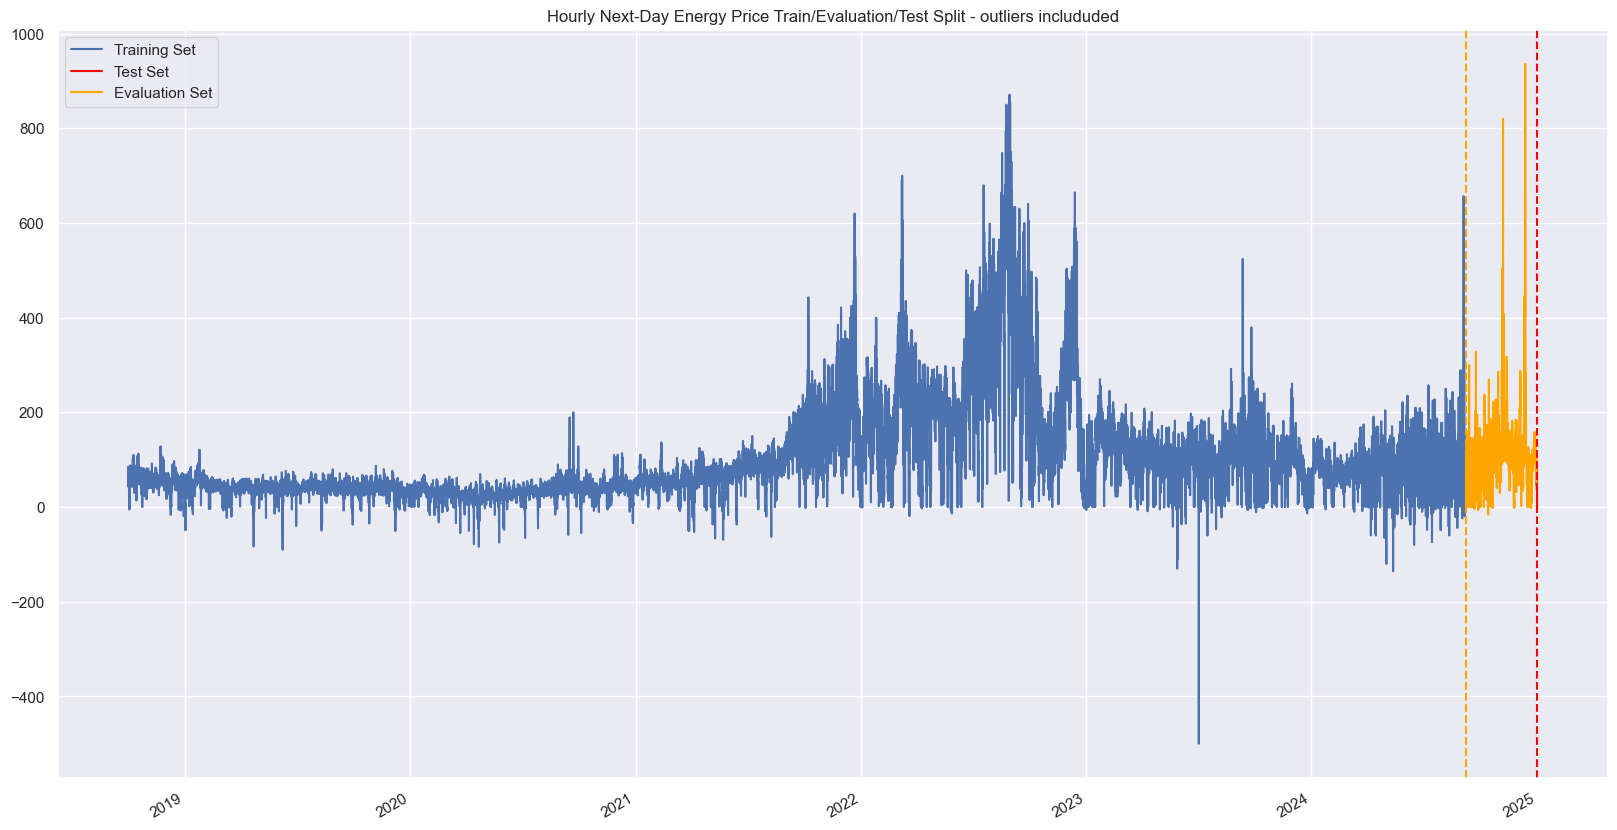

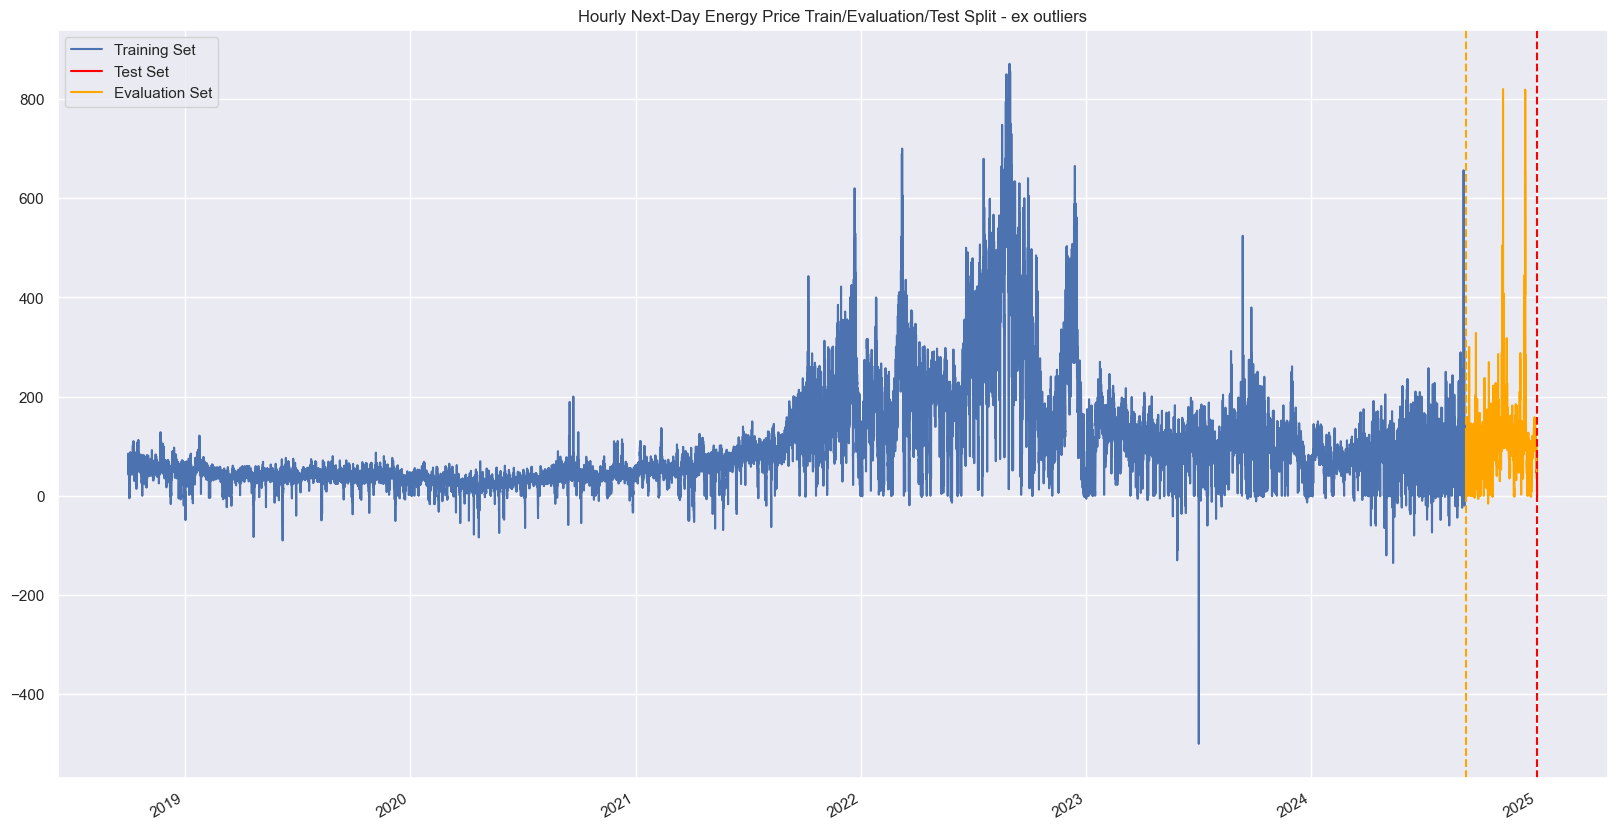

In [9]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [10]:
# lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
# lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [11]:
# best_params = {
#     "base_score": 0.380924762889507,
#     "early_stopping_rounds": 215,
#     "max_depth": 80,
#     "learning_rate": 0.06,
#     "n_estimators": 150,
#     "gamma": 0.9,
#     "min_child_weight": 6,
#     "subsample": 0.5719023844219375,
#     "colsample_bytree": 0.8815691043681952,
# }
# xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
# xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)


### Prophet

In [12]:
# # Initialize Prophet model
# model = Prophet(
#     changepoint_prior_scale = 0.5,
#     seasonality_prior_scale = 1.0,
#     holidays_prior_scale = 1.0,
#     seasonality_mode= 'multiplicative'
# )

# #Add fourier order for weekly and monthly seasonality
# model.add_seasonality(name='weekly', period=7, fourier_order=20)
# model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
# model.add_seasonality(name='yearly', period=365, fourier_order=20)

# # Add time-based regressors

# for feature in FEATURES:
#      model.add_regressor(feature)
     
# train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

# model.fit(train_data)

# test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
# test_data_prophet.drop(columns=["Price"])
# prophet_predictions = model.predict(test_data_prophet)["yhat"]


## Results

### Errors

In [13]:
# calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

### Plots

In [14]:
# predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

# plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

In [15]:
# feature_importance(xgb_mse, "MSE")
# feature_importance(xgb_mae, "MAE")

## Prediction

15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:56 - cmdstanpy - INFO - Chain [1] done processing


Prediction from 2025-01-01 23:00:00 to 2025-01-02 23:00:00


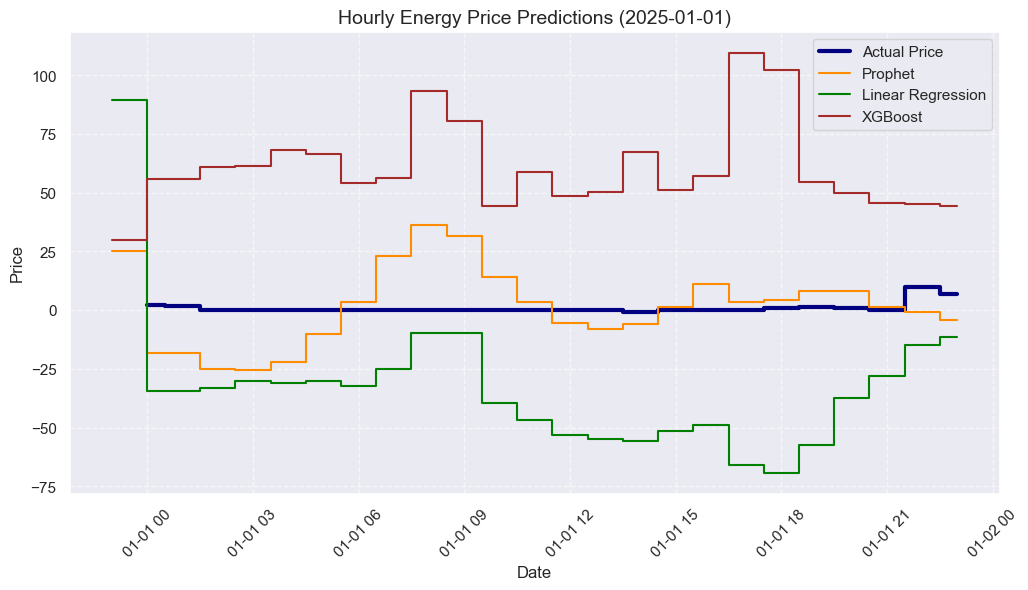

Prophet RMSE: 16.41301756886573
Linear Regression RMSE: 44.834096992116855
XGBoost RMSE: 62.77804089401439



15:45:10 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# =============================================================================
# Constants and Configurations
# =============================================================================

# Forecasting window settings
HOURS_IN_LAST_MONTH = 24 * 31  # Assuming 31 days in the last month
WINDOW_SIZE = 24             # Forecasting window of 24 hours

# Columns to use from the datasets
COLUMNS = [
    "Price", "Hydro", "Pumped storage generation", "Solar", 
    "Wind offshore", "Wind onshore", "temperature_2m", "precipitation", 
    "wind_speed_100m", "direct_radiation"
]

# Final features used for model training and forecasting
FINAL_FEATURES = [
    "hour", "dayofyear", "dayofweek",
    "Hydro", "Pumped storage generation",
    "Solar", "Wind offshore", "Wind onshore",
    "temperature_2m", "precipitation", "wind_speed_100m", "direct_radiation"
]

XGB_hyp_params = {
    "base_score": 0.380924762889507,
    # "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}

# =============================================================================
# Data Preparation
# =============================================================================

# Split the data into training and benchmarking sets
training_set = merged_df.iloc[:-HOURS_IN_LAST_MONTH][COLUMNS]
benchmarking_set = combined_df.iloc[-HOURS_IN_LAST_MONTH:].copy()

# List to hold RMSE values for each forecasting window
rmses = []

# =============================================================================
# Rolling Forecast Loop
# =============================================================================

for i in range(0, len(benchmarking_set) - WINDOW_SIZE, WINDOW_SIZE):
    # ------------------------- Prophet Model -------------------------
    # Initialize the Prophet model with custom features.
    prophet_model = init_prophet_model(FINAL_FEATURES)
    
    # Extract actual price values for the current 24-hour window.
    y_actual = benchmarking_set.iloc[i:i + WINDOW_SIZE]["Price"]

    # Extend the training data with any benchmarking data available before the current window.
    train_extended = pd.concat((training_set.copy(), benchmarking_set.iloc[:i]))
    train_extended = extend_by_predictions_and_samples(train_extended, train_extended.index[-1])
    train_extended_features = create_features(train_extended.copy())

    # Prepare data for Prophet: 
    # - The forecast dataframe requires a datetime column named "ds".
    prophet_forecast_data = (
        train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]
        .reset_index()
        .rename(columns={"index": "ds"})
    )

    # Prepare the training data for Prophet.
    prophet_training_data = (
        train_extended_features.iloc[:-WINDOW_SIZE][["Price"] + FINAL_FEATURES]
        .rename(columns={"Price": "y"})
        .reset_index()
        .rename(columns={"index": "ds"})
        .dropna()
    )

    # Fit the Prophet model and make predictions.
    prophet_model.fit(prophet_training_data)
    prophet_forecast = prophet_model.predict(prophet_forecast_data)["yhat"]

    # --------------------- Linear Regression Model ---------------------
    X_train_lr = train_extended_features.iloc[:-WINDOW_SIZE][FINAL_FEATURES]
    y_train_lr = train_extended_features.iloc[:-WINDOW_SIZE]["Price"]
    X_forecast_lr = train_extended_features.iloc[-WINDOW_SIZE:][FINAL_FEATURES]

    lr_model = LinearRegression()
    lr_model.fit(X_train_lr, y_train_lr)
    lr_forecast = lr_model.predict(X_forecast_lr)

    # ------------------------ XGBoost Model ------------------------
    xgb_model = XGBRegressor(**XGB_hyp_params)
    xgb_model.fit(X_train_lr, y_train_lr)
    xgb_forecast = xgb_model.predict(X_forecast_lr)

    # -------------------------- Plotting --------------------------
    # Determine the forecast time window for labeling the plot.
    start_time = train_extended.index[-1]
    end_time = start_time + timedelta(hours=WINDOW_SIZE)
    print(f"Prediction from {start_time} to {end_time}")

    # Adjusting x-ticks to properly align within the given range
    plt.figure(figsize=(12, 6))
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.step(y_actual.index, y_actual,linewidth=3, where="mid", label="Actual Price", color="navy")
    plt.step(prophet_forecast_data["ds"], prophet_forecast, linewidth=1.5, where="mid", label="Prophet", color="darkorange")
    plt.step(X_forecast_lr.index, lr_forecast, linewidth=1.5, where="mid", label="Linear Regression", color="green")
    plt.step(X_forecast_lr.index, xgb_forecast, linewidth=1.5, where="mid", label="XGBoost", color="brown")

    # Formatting the x-axis with properly aligned ticks
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title("Hourly Energy Price Predictions (2025-01-01)", fontsize=14)

    plt.xticks(rotation=45)
    plt.legend(fontsize=11)
    plt.show()

    # --------------------- RMSE Computation ---------------------
    prophet_rmse = mean_squared_error(y_actual, prophet_forecast) ** 0.5
    lr_rmse = mean_squared_error(y_actual, lr_forecast) ** 0.5
    xgb_rmse = mean_squared_error(y_actual, xgb_forecast) ** 0.5

    print(f"Prophet RMSE: {prophet_rmse}")
    print(f"Linear Regression RMSE: {lr_rmse}")
    print(f"XGBoost RMSE: {xgb_rmse}\n")

    rmses.append((prophet_rmse, lr_rmse, xgb_rmse))

# =============================================================================
# Average RMSE Reporting
# =============================================================================

avg_rmse = tuple(sum(x) / len(rmses) for x in zip(*rmses))
print(f"Average RMSEs - Prophet: {avg_rmse[0]}, Linear Regression: {avg_rmse[1]}, XGBoost: {avg_rmse[2]}")
